In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [2]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [3]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'
proj = 'full_bayesian'
model = 'v2'
dataset = 'KORA'
report_id = '10_1571866968.4002764'
sample_dir = f'{base_dir}/projects/{proj}/outs/{proj}_{dataset}_{model}/{proj}_{dataset}_{model}_predictions_{dataset}/*_samples/**'
mean_segs_dir = f'{base_dir}/projects/{proj}/outs/{proj}_{dataset}_{model}/{proj}_{dataset}_{model}_predictions_{dataset}/*_seg.nii.gz'
sample_paths = glob.glob(sample_dir)
mean_seg_paths = glob.glob(mean_segs_dir)
print(len(mean_seg_paths))
sample_paths.extend(mean_seg_paths)
print(len(sample_paths))

153
1683


In [4]:
sample_count_dict = {}
for r_id, sample in enumerate(sample_paths):
    print("\rProcessing {}/{}.".format(r_id, len(sample_paths)), end="")

    split_str = sample.split('/')[-1].split('.')[0]
    v_id = split_str.split('_')[0]
    sample_id = split_str.split('_')[-1]
    nifti_file = nb.load(sample)
    header = nifti_file.header
#     print(header)
    s_data = nifti_file.get_fdata()
    unique_vals, counts = np.unique(s_data, return_counts=True)
    if v_id not in sample_count_dict.keys():
        sample_count_dict[v_id] = {str(i)+'_spleen':None for i in range(10)}
        sample_count_dict[v_id].update({str(i)+'_liver':None for i in range(10)})
    if sample_id == 'seg':
        sample_count_dict[v_id]['seg_liver'] = counts[2]
        sample_count_dict[v_id]['seg_spleen'] = counts[1]
    else:
        sample_count_dict[v_id][str(sample_id)+'_liver'] = counts[2]    
        sample_count_dict[v_id][str(sample_id)+'_spleen'] = counts[1] 

print(sample_count_dict)



df = pd.DataFrame.from_dict(sample_count_dict, orient="index")
df.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_sample_count_report.csv', index_label='volume_id')


Processing 1682/1683.{'KORA2452967': {'0_spleen': 13603, '1_spleen': 13607, '2_spleen': 13358, '3_spleen': 13115, '4_spleen': 13364, '5_spleen': 13183, '6_spleen': 13742, '7_spleen': 13596, '8_spleen': 13839, '9_spleen': 13099, '0_liver': 111216, '1_liver': 110921, '2_liver': 111840, '3_liver': 110581, '4_liver': 110554, '5_liver': 110323, '6_liver': 110944, '7_liver': 112776, '8_liver': 110981, '9_liver': 110375, 'seg_liver': 110171, 'seg_spleen': 13092}, 'KORA2459526': {'0_spleen': 20517, '1_spleen': 20684, '2_spleen': 20845, '3_spleen': 20261, '4_spleen': 20847, '5_spleen': 21022, '6_spleen': 19993, '7_spleen': 20430, '8_spleen': 21223, '9_spleen': 20741, '0_liver': 187026, '1_liver': 186150, '2_liver': 186451, '3_liver': 183833, '4_liver': 185733, '5_liver': 186548, '6_liver': 187055, '7_liver': 186037, '8_liver': 181560, '9_liver': 184808, 'seg_liver': 181600, 'seg_spleen': 20389}, 'KORA2455268': {'0_spleen': 7093, '1_spleen': 6723, '2_spleen': 7070, '3_spleen': 7169, '4_spleen': 

In [5]:
df['seg_spleen'] = df['seg_spleen'].apply(lambda x: x*12)
df['seg_liver'] = df['seg_liver'].apply(lambda x: x*12)

In [6]:
def z_score_normalise(vals):
    print(np.mean(vals), np.std(vals))
    return (vals - np.mean(vals)) / np.std(vals)

In [7]:

# x = z_score_normalise(x)
df['seg_spleen'] = (df['seg_spleen'] - df['seg_spleen'].mean())/df['seg_spleen'].std(ddof=0)
df['seg_liver'] = (df['seg_liver'] - df['seg_liver'].mean())/df['seg_liver'].std(ddof=0)


In [8]:
df['seg_spleen']


KORA2452967   -0.355930
KORA2459526    0.661858
KORA2455268   -1.228658
KORA2454788    0.245649
KORA2453589    0.256946
                 ...   
KORA2460504   -0.604066
KORA2460216    0.373970
KORA2452409   -1.425326
KORA2452190   -0.281169
KORA2453290    0.855457
Name: seg_spleen, Length: 153, dtype: float64

In [9]:

df.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_sample_count_report.csv', index_label='volume_id')

In [10]:
df = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_sample_count_report.csv')

In [11]:
df['seg_spleen']

0     -0.355930
1      0.661858
2     -1.228658
3      0.245649
4      0.256946
         ...   
148   -0.604066
149    0.373970
150   -1.425326
151   -0.281169
152    0.855457
Name: seg_spleen, Length: 153, dtype: float64

In [12]:
# df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv.csv')
# df_k_feats['volume_id'] = 'KORA' + df_k_feats['mrt-image-id'].astype(str)
# df_k_feats.to_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')
df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')

In [13]:
df_reports = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_report.csv')

In [14]:
df_k_feats.tranpose().head(200)


AttributeError: 'DataFrame' object has no attribute 'tranpose'

In [ ]:
df

In [15]:
df_merged = pd.merge(df, df_k_feats, how='inner', on=['volume_id']) #pd.concat([df, df_k_feats], join='inner', keys='volume_id')
print(df_merged.transpose().head(200))
df_merged_final = pd.merge(df_merged, df_reports, how='inner', on=['volume_id'])
df_merged_final.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_concat_report_final.csv')

                                   0            1            2            3    \
volume_id                  KORA2452967  KORA2459526  KORA2455268  KORA2454788   
0_spleen                         13603        20517         7093        17632   
1_spleen                         13607        20684         6723        17322   
2_spleen                         13358        20845         7070        17204   
3_spleen                         13115        20261         7169        17672   
...                                ...          ...          ...          ...   
bmi-who_normal                       1            0            0            1   
bmi-who_obesity class I              0            0            0            0   
bmi-who_obesity class II             0            0            0            0   
bmi-who_obesity class III            0            0            0            0   
bmi-who_pre-obisety                  0            1            1            0   

                           

In [16]:
df = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_concat_report_final.csv')

In [17]:
df['seg_spleen']

0     -0.355930
1      0.661858
2     -1.228658
3      0.245649
4      0.256946
         ...   
148   -0.604066
149    0.373970
150   -1.425326
151   -0.281169
152    0.855457
Name: seg_spleen, Length: 153, dtype: float64

In [18]:
good_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
             'hba1c-mmol/mol', 'cholesterol-hdl', 'age', 'blood-pressure-diastolic', 'blood-pressure-systolic',
             'sex', 'bmi-numeric']

smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non-smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi-numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight' ]
vols_feat = ['seg_liver', 'seg_spleen']

In [19]:
all_feats = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, vols_feat]
feats = flatten(all_feats)
df = df.fillna(0)
p_values = {}
y = df["diabetes_status"].copy()
y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
# print(y_classes, pd.get_dummies(y).values)
for f in feats:
    try:
        X = pd.get_dummies(df.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0])
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


,coeff,p_value
age,0.008857,1.232938e-15
height,0.002735,8.371145e-14
sex,0.615385,4.480111e-14
weight,0.006076,5.552860e-17
smoker_former,0.514706,1.934475e-07
smoker_irregular,0.333333,2.394919e-01
smoker_non-smoker,0.423077,2.523419e-04
smoker_regular,0.500000,3.555895e-03
smoking-packages,0.014308,1.977551e-05
bmi-who_normal,0.190476,1.460153e-01


In [20]:

p_value_df.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_p_values.csv', index_label='feats')
        

In [21]:
categorical_features = ['diabetes_status']
for f in categorical_features:
    dfDummies = pd.get_dummies(df[f], prefix = f)
    df_c = pd.concat([df, dfDummies], axis=1)

In [22]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_spleen"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,-0.000583,0.686873
height,0.000112,0.813133
sex,0.274193,0.008473
weight,0.001110,0.244653
smoker_former,0.191270,0.115039
smoker_irregular,0.184479,0.581638
smoker_non-smoker,-0.140307,0.313220
smoker_regular,-0.307112,0.132908
smoking-packages,0.004860,0.231746
bmi-who_normal,-0.605470,0.000061


In [23]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_liver"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         print(X)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,-0.000665,6.451920e-01
height,0.000096,8.388764e-01
sex,0.228377,2.888974e-02
weight,0.001484,1.192136e-01
smoker_former,0.060984,6.166368e-01
smoker_irregular,-0.121934,7.157954e-01
smoker_non-smoker,-0.023995,8.632911e-01
smoker_regular,-0.075074,7.143199e-01
smoking-packages,0.002179,5.925604e-01
bmi-who_normal,-0.578407,1.332743e-04


In [24]:
# all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
#              mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, ['diabetes_status']]

mod_s = []
all_feats_simple = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight']]
all_feats_simple1 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['bmi-numeric']]
all_feats_simple2 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight', 'bmi-numeric']]
all_feats_simple3 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]
for feats_list in [all_feats_simple1]:
    feats = flatten(feats_list)
    df_c = df_c.fillna(0)
    p_values = {}
    for target in ['seg_liver', 'seg_spleen']:
        print(target)
        for i in range(2):
            
            y = df_c[target].copy()
    #         print(y.values)
    #         y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
            y_classes = y.values
            if i==0:
                continue
                print('iou as multiplier')
                target_prefix = target.split('_')[1]
                ious = df_c['iou_'+target_prefix].values
#                 print(y_classes[0:10], ious[0:10])
                y_classes = np.multiply(y_classes, ious)
#                 print(y_classes[0:10])
    #         print(y_classes)
            try:
                print(feats)
                X = pd.get_dummies(df_c.loc[y.index, feats], drop_first=True)
            #         X = X.fillna(0)
                mod = sm.OLS(y_classes, X)
                mod_ = ols("y_classes ~ X", df_c).fit()
                mod_s.append(mod_)
                table = sm.stats.anova_lm(mod_) # Type 2 Anova DataFrame
                print('------------------------------------------------------------')
                print(table)
                fii = mod.fit()
                print(fii.summary())
                df_fii = pd.read_html(fii.summary().tables[1].as_html(),header=0,index_col=0)[0]
#                 print(df_fii)
            #         print(f, fii.pvalues.values[0], fii.params.values)
                p_values[f] = {'coeff': fii.params.values, 'p_value':fii.pvalues.values}
            except Exception as e:
                print(e)

# full_table = sm.stats.anova_lm(mod_s) # Type 2 Anova DataFrame
# print(full_table)
# print(p_values)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df

seg_liver
['age', 'sex', 'diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2', 'bmi-numeric']
------------------------------------------------------------
             df     sum_sq   mean_sq          F        PR(>F)
X           6.0  59.566743  9.927790  15.606108  8.227511e-14
Residual  147.0  93.513718  0.636148        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     18.70
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           2.34e-14
Time:                        15:58:52   Log-Likelihood:                -179.43
No. Observations:                 153   AIC:                             370.9
Df Residuals:                     147   BIC:                             389.1
Df Model:         

In [25]:
df_c.rename(columns={'bmi-numeric':'bmi_numeric'}, 
                 inplace=True)

In [26]:
mod_liver = ols('seg_liver ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()
mod_spleen = ols('seg_spleen ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()

In [27]:

full_table = sm.stats.anova_lm(mod_liver) # Type 2 Anova DataFrame
print(full_table)

                      df     sum_sq    mean_sq          F        PR(>F)
age                  1.0   8.000759   8.000759  12.576888  5.243495e-04
sex                  1.0  11.756118  11.756118  18.480170  3.110559e-05
bmi_numeric          1.0  38.939795  38.939795  61.211874  9.210997e-13
diabetes_status_0    1.0   0.753937   0.753937   1.185160  2.780897e-01
diabetes_status_1    1.0   0.035673   0.035673   0.056077  8.131373e-01
diabetes_status_2    1.0   0.000452   0.000452   0.000711  9.787702e-01
Residual           147.0  93.513718   0.636148        NaN           NaN


In [28]:

full_table = sm.stats.anova_lm(mod_spleen) # Type 2 Anova DataFrame
print(full_table)

                      df      sum_sq    mean_sq          F    PR(>F)
age                  1.0    6.132861   6.132861   7.549256  0.006755
sex                  1.0   16.929136  16.929136  20.838948  0.000010
bmi_numeric          1.0   10.401750  10.401750  12.804052  0.000469
diabetes_status_0    1.0    0.049991   0.049991   0.061536  0.804430
diabetes_status_1    1.0    0.066465   0.066465   0.081815  0.775255
diabetes_status_2    1.0    0.261511   0.261511   0.321907  0.571329
Residual           147.0  119.419797   0.812380        NaN       NaN


In [29]:
df_normal = df[df['diabetes_status']==0]
df_pre_diabetic = df[df['diabetes_status']==1]
df_diabetic = df[df['diabetes_status']==2]

In [ ]:
boxplot = df_pre_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("pre_diabetic")
boxplot.set_ylabel("Dice Score")

In [ ]:
boxplot = df_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("diabetic")
boxplot.set_ylabel("Dice Score")

In [ ]:
boxplot = df_normal[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("normal")
boxplot.set_ylabel("Dice Score")

In [30]:

df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [ ]:
dfs[['normal_dice_spleen', 'normal_dice_liver', 'pre_diabetic_dice_spleen', 'pre_diabetic_dice_liver', 'diabetic_dice_spleen', 'diabetic_dice_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'pre_diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs pre_diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('pre_diabetic_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'pre_diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs pre_diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('pre_diabetic_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

In [ ]:
dfs[['normal_iou_spleen', 'normal_iou_liver', 'pre_diabetic_iou_spleen', 'pre_diabetic_iou_liver', 'diabetic_iou_spleen', 'diabetic_iou_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'pre_diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs pre_diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('pre_diabetic_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'pre_diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs pre_diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('pre_diabetic_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

In [ ]:
dfs[['normal_surface_distance_prtogt_spleen', 'normal_surface_distance_prtogt_liver', 'pre_diabetic_surface_distance_prtogt_spleen', 'pre_diabetic_surface_distance_prtogt_liver', 'diabetic_surface_distance_prtogt_spleen', 'diabetic_surface_distance_prtogt_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs pre_diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs pre_diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

In [ ]:
dfs[['normal_surface_distance_gttopr_spleen', 'normal_surface_distance_gttopr_liver', 'pre_diabetic_surface_distance_gttopr_spleen', 'pre_diabetic_surface_distance_gttopr_liver', 'diabetic_surface_distance_gttopr_spleen', 'diabetic_surface_distance_gttopr_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs pre_diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs pre_diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

In [ ]:
dfs[['normal_surface_distance_avg_spleen', 'normal_surface_distance_avg_liver', 'pre_diabetic_surface_distance_avg_spleen', 'pre_diabetic_surface_distance_avg_liver', 'diabetic_surface_distance_avg_spleen', 'diabetic_surface_distance_avg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)

print('normal_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_avg_spleen'].dropna().values)
print('normal_surface_distance_avg_spleen vs diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)
print('diabetic_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('diabetic_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')


In [ ]:
# dfs[['normal_iou_mean', 'normal_dice_mean', 'pre_diabetic_iou_mean', 'pre_diabetic_dice_mean', 'diabetic_iou_mean', 'diabetic_dice_mean']].boxplot(rot=45)
dfs[[ 'normal_dice_mean', 'pre_diabetic_dice_mean', 'diabetic_dice_mean']].boxplot(rot=45)

# dfs['normal_dice_mean'].dropna().values



t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)

print('normal_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'diabetic_dice_mean'].dropna().values)
print('normal_dice_mean vs diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)
print('diabetic_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')


In [ ]:
dfs[['normal_ged', 'normal_sncc', 'pre_diabetic_ged', 'pre_diabetic_sncc', 'diabetic_ged', 'diabetic_sncc']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)

print('normal_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)
print('diabetic_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'diabetic_ged'].dropna().values)
print('normal_ged vs diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'pre_diabetic_sncc'].dropna().values)
print('normal_sncc vs pre_diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('normal_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('pre_diabetic_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

In [ ]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_seg_spleen vs pre_diabetic_seg_spleen
t: -0.8177259246438733
p: 0.41498729740662355


normal_seg_spleen vs diabetic_seg_spleen
t: -1.3170690710458164
p: 0.19038918753533732


diabetic_seg_spleen vs pre_diabetic_seg_spleen
t: 0.6343207247427077
p: 0.5287067176374092


normal_seg_liver vs pre_diabetic_seg_liver
t: -2.7927011599875353
p: 0.006004489830271225


normal_seg_liver vs diabetic_seg_liver
t: -2.8524495521751283
p: 0.005131034557380649


diabetic_seg_liver vs pre_diabetic_seg_liver
t: 0.08230652521899437
p: 0.9347251532047067




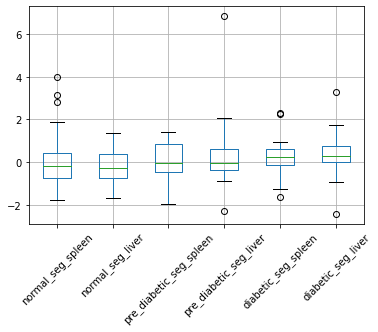

In [31]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

In [63]:
# sm.regression.linear_model.WLS.fit_regularized('seg_liver ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
#            , df_c)
mod_liver = ols('seg_liver ~ age+ sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2', df_c).fit_regularized(L1_wt=0.5, refit=True)
# mod_spleen = ols('seg_spleen ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
#            , df_c).fit()

In [83]:
df_c['iou_liver_weights'] = df_c['iou_liver'].apply(lambda x: 1/(1-x))

In [74]:
df_c['iou_liver_weights'] = (df_c['iou_liver_weights'] - df_c['iou_liver_weights'].min())/(df_c['iou_liver_weights'].max()-df_c['iou_liver_weights'].min())

In [84]:
df_c['iou_liver_weights'] .values

array([2.59955723, 3.20782925, 3.12751112, 3.00189732, 3.57966658,
       5.2091174 , 3.18986646, 2.48119996, 1.56511048, 2.99924726,
       3.8898153 , 2.09268529, 3.65914649, 4.10410669, 4.05863954,
       3.27822926, 4.33954451, 2.37868999, 3.7212958 , 2.56210739,
       3.87574707, 3.22656812, 3.49118929, 2.0897434 , 3.67065489,
       3.06233274, 2.62353782, 1.53488309, 5.16539876, 3.70845054,
       4.26957387, 3.08285856, 3.28672639, 1.40025039, 3.68797201,
       2.51787613, 2.32699829, 3.79324444, 3.97658094, 4.61811628,
       2.10252777, 3.65707586, 1.55087754, 2.46462679, 2.6652014 ,
       2.20562332, 2.15957905, 4.41433602, 4.72312512, 2.96030112,
       5.33862981, 3.4485392 , 2.8082161 , 2.45807247, 3.24942435,
       4.62777028, 3.65811256, 4.15125082, 3.75928184, 3.94020304,
       1.13997116, 4.07949938, 4.14594088, 3.77368165, 2.82600852,
       3.25666475, 2.75368845, 2.51141292, 2.69701345, 2.4391127 ,
       2.65695841, 4.05107984, 3.44883672, 3.23666042, 4.22967

In [128]:
mod_liver_normal_fit = ols('seg_liver ~ age+sex+bmi_numeric+diabetes_status_0+diabetes_status_1+diabetes_status_2', df_c).fit()

In [129]:
mod_liver_normal_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              seg_liver   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     18.70
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           2.34e-14
Time:                        16:42:21   Log-Likelihood:                -179.43
No. Observations:                 153   AIC:                             370.9
Df Residuals:                     147   BIC:                             389.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8248      0.483     -1.708      0.090      -1.779       0.130
age                  -0.0307      0.007     -4.124      0.000      -0.045      -0.016
sex                   0.3433      0.137      2.515      0.013       0.074       0.613
bmi_numeric           0.0941      0.014      6.552      0.000       0.066       0.122
diabetes_status_0    -0.3878      0.131     -2.968      0.004      -0.646      -0.130
diabetes_status_1    -0.1914      0.217     -0.883      0.379      -0.619       0.237
diabetes_status_2    -0.2457      0.243     -1.012      0.313      -0.725       0.234
==============================================================================
Omnibus:                      113.033   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2537.658
Skew:                           2.207   Prob(JB):                         0.00
Kurtosis:                      22.457   Cond. No.                     6.26e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.54e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [131]:
mod_liver = ols('seg_liver ~ age+sex+bmi_numeric+diabetes_status_0+diabetes_status_1+diabetes_status_2', df_c).fit_regularized(alpha=df_c['iou_liver_weights'].values, L1_wt=0.001,refit=True)

In [132]:
# full_table = sm.stats.anova_lm(mod_liver) # Type 2 Anova DataFrame
mod_liver.summary()
# print(mod_liver.params)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              seg_liver   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     13.27
Date:                Tue, 29 Oct 2019   Prob (F-statistic):           3.56e-13
Time:                        16:42:52   Log-Likelihood:                -179.43
No. Observations:                 153   AIC:                             374.9
Df Residuals:                     146   BIC:                             399.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8248      0.485     -1.702      0.091      -1.783       0.133
age                  -0.0307      0.007     -4.110      0.000      -0.045      -0.016
sex                   0.3433      0.137      2.506      0.013       0.073       0.614
bmi_numeric           0.0941      0.014      6.529      0.000       0.066       0.123
diabetes_status_0    -0.3878      0.131     -2.958      0.004      -0.647      -0.129
diabetes_status_1    -0.1914      0.217     -0.880      0.380      -0.621       0.238
diabetes_status_2    -0.2457      0.244     -1.008      0.315      -0.727       0.236
==============================================================================
Omnibus:                      113.033   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2537.658
Skew:                           2.207   Prob(JB):                         0.00
Kurtosis:                      22.457   Cond. No.                     6.89e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.27e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
dfs['normal_seg_spleen_iou'] = dfs['normal_seg_spleen'] * dfs['normal_iou_spleen']
dfs['normal_seg_liver_iou'] = dfs['normal_seg_liver'] * dfs['normal_iou_liver']
dfs['pre_diabetic_seg_spleen_iou'] = dfs['pre_diabetic_seg_spleen'] * dfs['pre_diabetic_iou_spleen']
dfs['pre_diabetic_seg_liver_iou'] = dfs['pre_diabetic_seg_liver'] * dfs['pre_diabetic_iou_liver']
dfs['diabetic_seg_spleen_iou'] = dfs['diabetic_seg_spleen'] * dfs['diabetic_iou_spleen']
dfs['diabetic_seg_liver_iou'] = dfs['diabetic_seg_liver'] * dfs['diabetic_iou_liver']


In [ ]:
dfs[['normal_seg_spleen_iou', 'normal_seg_liver_iou', 'pre_diabetic_seg_spleen_iou', 'pre_diabetic_seg_liver_iou', 'diabetic_seg_spleen_iou', 'diabetic_seg_liver_iou']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen_iou'].dropna().values, dfs[ 'pre_diabetic_seg_spleen_iou'].dropna().values)

print('normal_seg_spleen_iou vs pre_diabetic_seg_spleen_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen_iou'].dropna().values, dfs[ 'diabetic_seg_spleen_iou'].dropna().values)
print('normal_seg_spleen_iou vs diabetic_seg_spleen_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_seg_spleen_iou'].dropna().values, dfs[ 'diabetic_seg_spleen_iou'].dropna().values)
print('pre_diabetic_seg_spleen_iou vs diabetic_seg_spleen_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver_iou'].dropna().values, dfs[ 'pre_diabetic_seg_liver_iou'].dropna().values)
print('normal_seg_liver_iou vs pre_diabetic_seg_liver_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver_iou'].dropna().values, dfs[ 'diabetic_seg_liver_iou'].dropna().values)
print('normal_seg_liver_iou vs diabetic_seg_liver_iou')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_seg_liver_iou'].dropna().values, dfs[ 'diabetic_seg_liver_iou'].dropna().values)
print('pre_diabetic_seg_liver_iou vs diabetic_seg_liver_iou')
print('t:', t)
print('p:', p)
print('\n')